In [1]:
%%capture
!pip install "burr[start]"
!pip install opentelemetry-instrumentation-openai

# OpenTelemetry

In this notebook we'll instrument a simple Burr app with [OpenTelemetry](www.opentelemetry.io). See the [docs](https://burr.dagworks.io/concepts/additional-visibility/) for more information.

# Our application

Let's take a look at the graph we've defined in [application.py](./application.py). As you can see, it's a simple multi-modal chatbot.

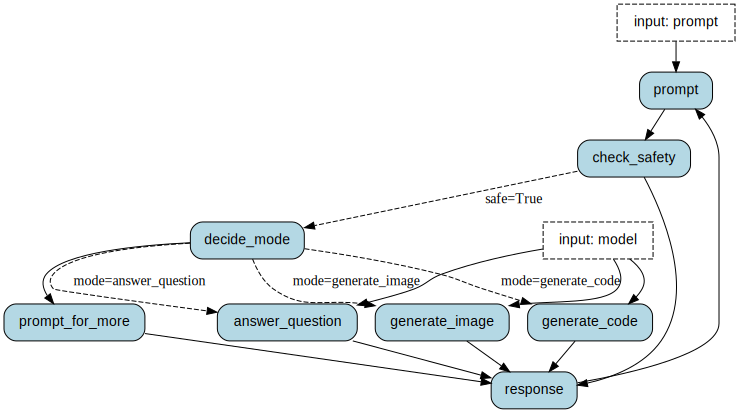

In [3]:
from application import graph
graph

# Building the application 

We're going to instrument this with OpenTelemetry -- first using Burr as the provider then using [Traceloop](traceloop.com). There are reasons to use them both, and you can use them together!

First, let's use Burr to build an application (vanilla) and run it:

In [4]:
from burr.core import ApplicationBuilder
app = (
    ApplicationBuilder()
    .with_entrypoint("prompt")
    .with_state(chat_history=[])
    .with_graph(graph)
    .build()
)
app.run(inputs={"prompt":"What is the capital of France?"}, halt_after=["response"])

# Instrumenting with OpenLLMetry

The [OpenLLMetry](https://github.com/traceloop/openllmetry) library provides a set of integrations that automatically instrument LLM libraries with OpenTelemetry.
In this case we'll be using the [OpenAI instrumentor](https://pypi.org/project/opentelemetry-instrumentation-openai/).

The following automatically instruments a set of attributes/spans for us:

In [5]:
from opentelemetry.instrumentation.openai import OpenAIInstrumentor
OpenAIInstrumentor().instrument()

 Burr also provides a convenience function `init_instruments()` to instrument common 3rd party libraries.

In [6]:
from burr.integrations.opentelemetry import init_instruments

init_instruments("openai")

You can specify `init_all=True` instead of passing individual libraries as string. This will try to instrument currently imported libraries with the available instrumentation package you have installed (find some more [here](https://github.com/open-telemetry/opentelemetry-python-contrib/tree/main/instrumentation) and [here](https://github.com/traceloop/openllmetry/tree/main/packages)).

You can get the logger to view which library is successfully instrumented.

In [7]:
import logging
logger = logging.getLogger("burr.integrations.opentelemetry")
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.DEBUG)

In [8]:
init_instruments(init_all=True)

Instrumenting all libraries.
`openai` is already instrumented.
`anthropic` wasn't imported. Skipping instrumentation.
`cohere` wasn't imported. Skipping instrumentation.
`google.generativeai` wasn't imported. Skipping instrumentation.
`mistralai` wasn't imported. Skipping instrumentation.
`ollama` wasn't imported. Skipping instrumentation.
`transformers` wasn't imported. Skipping instrumentation.
`together` wasn't imported. Skipping instrumentation.
`bedrock` wasn't imported. Skipping instrumentation.
`replicate` wasn't imported. Skipping instrumentation.
`vertexai` wasn't imported. Skipping instrumentation.
`groq` wasn't imported. Skipping instrumentation.
`ibm-watsonx-ai` wasn't imported. Skipping instrumentation.
`aleph_alpha_client` wasn't imported. Skipping instrumentation.
`pinecone` wasn't imported. Skipping instrumentation.
`qdrant_client` wasn't imported. Skipping instrumentation.
`chromadb` wasn't imported. Skipping instrumentation.
`pymilvus` wasn't imported. Skipping instru

# Tracking on Traceloop

To follow this you'll need an API key for traceloop -- you can sign up for the free 
tier at [traceloop.com](traceloop.com).

We can then build the application and track on traceloop. 

We:
1. Initialize traceloop
2. add the OpenTelemetryBridge hook to Burr -- this sets it up to capture Burr framework events as part of Open Telemetry

Note you can use any OpenTelemetry provider -- traceloop is specifically built for this, however, and has a variety of LLM-specific integrations.

Once you run this, visit [traceloop](app.traceloop.com) to see your traces!

In [ ]:
from traceloop.sdk import Traceloop
import os
from burr.integrations import opentelemetry
from burr.core import ApplicationBuilder

from traceloop.sdk import Traceloop

Traceloop.init(api_key=os.environ["TRACELOOP_API_KEY"])
               
app_otel = (
    ApplicationBuilder()
    .with_entrypoint("prompt")
    .with_state(chat_history=[])
    .with_graph(graph)
    .with_hooks(opentelemetry.OpenTelemetryBridge())
    .build()
)
app.run(inputs={"prompt":"What is the capital of France?"}, halt_after=["response"])

# Tracking on Burr

You can also view on the Burr local tracker! This is good for local debugging and can go hand-in-hand with traceloop.

To do so, all you need to do is add the `use_otel_tracing=True` parameter to `with_tracker`.

In [ ]:
app = (
    ApplicationBuilder()
    .with_entrypoint("prompt")
    .with_state(chat_history=[])
    .with_graph(graph)
    .with_tracker(
        project="demo_opentelemetry",
        use_otel_tracing=True)
    .build()
)

app.run(inputs={"prompt":"What is the capital of France?"}, halt_after=["response"])

# Viewing in UI

The following cell gives you a link to the prior run in the UI. If you have not yet, run `burr` in your terminal to start the local tracking server.

In [ ]:
from IPython.display import Markdown
url = f"[Link to UI](http://localhost:7241/project/demo_tracing/null/{app.uid})"
Markdown(url)